(loo_notebook)=
# Validazione Incrociata Leave-One-Out

```{admonition} Obiettivi di apprendimento
Dopo aver completato questo capitolo, acquisirete le competenze per:

- comprendere il concetto di validazione incrociata Leave-One-Out;
- calcolare LOO-CV usando ArviZ;
- usare LOO-CV nel confronto tra modelli;
- comprendere e calcolare i valori diagnostici Pareto $k$.
```

Come evidenziato nel precedente capitolo, uno dei metodi più efficaci e ampiamente utilizzati per stimare la Densità Predittiva Logaritmica Attesa (ELPD) è la validazione incrociata Leave-One-Out (LOO-CV). Rispetto ad altri approcci che utilizzano l'intero set di dati per valutare le performance del modello, il metodo LOO-CV esclude una singola osservazione alla volta dal dataset, addestra il modello sui dati rimanenti e successivamente valuta la sua capacità di predire l'osservazione esclusa. Questo procedimento viene ripetuto per ogni osservazione presente nel dataset, fornendo così un'analisi dettagliata e approfondita della capacità del modello di generalizzare al di fuori dei dati osservati. Nel presente capitolo, esamineremo attentamente la metodologia LOO-CV e illustreremo come essa possa essere utilizzata per calcolare l'ELPD.

In [1]:
import os
import itertools
import logging
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import cmdstanpy
from cmdstanpy import CmdStanModel
cmdstanpy.utils.get_logger().setLevel(logging.ERROR)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import arviz as az
from scipy import stats
import pingouin as pg

In [2]:
# set seed to make the results fully reproducible
seed: int = sum(map(ord, "stan_loo"))
rng: np.random.Generator = np.random.default_rng(seed=seed)

az.style.use("arviz-darkgrid")
plt.rcParams["figure.dpi"] = 100
plt.rcParams["figure.facecolor"] = "white"

# Get the home directory
home_directory = os.path.expanduser("~")
# Construct the path to the Quarto project directory 
project_directory = os.path.join(
    home_directory, '_repositories', 'ds4p')

%config InlineBackend.figure_format = "retina"

# Introduzione ai Metodi Bayesiani: Valutazione e Selezione dei Modelli

## Il Problema del Sovra-adattamento

Quando costruiamo un modello statistico, uno dei problemi più comuni che possiamo incontrare è il **sovra-adattamento** (in inglese, "overfitting"). Ma cosa significa esattamente?

Immaginate di provare a disegnare una linea che passi attraverso un gruppo di punti su un grafico. Se la linea passa esattamente per ogni singolo punto, potrebbe sembrare perfetta, vero? In realtà, questo potrebbe essere un esempio di sovra-adattamento.

Il sovra-adattamento si verifica quando un modello si adatta troppo bene ai dati che abbiamo usato per crearlo (chiamati "dati di addestramento"). In questo processo, il modello inizia a catturare non solo le tendenze generali nei dati (il "segnale"), ma anche le fluttuazioni casuali o gli errori (il "rumore").

### Perché il sovra-adattamento è un problema?

Un modello sovra-adattato funzionerà benissimo con i dati di addestramento, ma avrà prestazioni scarse quando lo useremo con nuovi dati. È come se il modello avesse "imparato a memoria" i dati di addestramento invece di capire le regole generali che li governano.

Per evitare il sovra-adattamento, dobbiamo trovare un equilibrio tra la capacità del modello di adattarsi ai dati di addestramento e la sua capacità di generalizzare a nuovi dati. Questo è ciò che chiamiamo il "trade-off" tra bias e varianza.

## Tecniche di Validazione

Per assicurarci che il nostro modello non stia sovra-adattandosi, usiamo delle tecniche chiamate "tecniche di validazione". Una delle più importanti è la **validazione incrociata** (cross-validation).

### Validazione Incrociata (Cross-Validation)

La validazione incrociata è come fare un "test di realtà" per il nostro modello. Invece di usare tutti i dati per addestrare il modello e poi testarlo, dividiamo i dati in parti e usiamo alcune parti per l'addestramento e altre per il test, in modo ripetuto.

Ci sono diversi tipi di validazione incrociata, ma vediamo due dei più comuni:

1. **K-fold cross-validation**:
   - Immaginate di avere un mazzo di carte. Le mescolate e le dividete in K gruppi (chiamate "fold").
   - Prendete K-1 gruppi per addestrare il modello e usate il gruppo rimanente per testarlo.
   - Ripetete questo processo K volte, ogni volta usando un gruppo diverso per il test.
   - Alla fine, fate la media dei risultati di tutti i test.

   Per esempio, se K = 5, dividerete i dati in 5 parti, addestrerete il modello su 4 parti e lo testerete sulla quinta, ripetendo questo processo 5 volte.

2. **Leave-one-out cross-validation (LOO-CV)**:
   - Questa è una versione estrema della K-fold, dove K è uguale al numero totale di osservazioni.
   - Prendete tutti i dati tranne uno per addestrare il modello, e usate quello lasciato fuori per testarlo.
   - Ripetete questo processo per ogni singola osservazione nel dataset.

   È come se steste giocando a "indovina chi" con i vostri dati, cercando di prevedere ogni singola osservazione basandovi su tutte le altre.

Queste tecniche ci aiutano a capire quanto bene il nostro modello si comporterà con dati nuovi, che non ha mai visto prima.

## Criteri di Informazione

Oltre alla validazione incrociata, usiamo anche i "criteri di informazione" per valutare i nostri modelli. Questi criteri ci aiutano a bilanciare due aspetti importanti:
1. quanto bene il modello si adatta ai dati;
2. quanto è complesso il modello.

Vediamo alcuni dei criteri più comuni:

### Errore Quadratico Medio (MSE)

L'Errore Quadratico Medio (in inglese, Mean Squared Error o MSE) misura quanto le previsioni del nostro modello si discostano dai valori reali. È come misurare la distanza media tra i punti dei nostri dati e la linea (o curva) che il nostro modello ha disegnato.

La formula matematica è:

$$ MSE = \frac{1}{n} \sum_{i=1}^{n} (y_i - \hat{y}_i)^2, $$

dove:
- $n$ è il numero totale di osservazioni.
- $y_i$ sono i valori reali,
- $\hat{y}_i$ sono i valori previsti dal modello.

Un MSE più basso indica che il modello si adatta meglio ai dati.

### Criterio di Informazione di Akaike (AIC)

Il Criterio di Informazione di Akaike (AIC) va un passo oltre l'MSE. Non solo guarda quanto bene il modello si adatta ai dati, ma considera anche quanto è complesso il modello.

La formula dell'AIC è:

$$ AIC = -2 \sum \log p(y_i \mid \hat{\theta}_{\text{mle}}) + 2k, $$

dove:
- $\hat{\theta}_{\text{mle}}$ sono i parametri stimati del modello,
- $k$ è il numero di parametri del modello.

L'idea è che un modello migliore dovrebbe adattarsi bene ai dati (prima parte della formula) senza essere troppo complesso (seconda parte della formula). Un AIC più basso indica un modello migliore.

### Widely Applicable Information Criterion (WAIC)

Il WAIC è una versione più avanzata dell'AIC, particolarmente utile nel contesto bayesiano. Invece di considerare solo la stima puntuale dei parametri, il WAIC tiene conto dell'intera distribuzione a posteriori dei parametri.

La formula del WAIC è più complessa:

$$ WAIC = -2\left[ \sum_{i=1}^{n} \log \left( \frac{1}{S} \sum_{s=1}^{S} p(y_i|\theta^{(s)}) \right) - \sum_{i=1}^{n} \text{Var}_{\theta^{(s)}} \left( \log p(y_i|\theta^{(s)}) \right) \right], $$

dove:
- $S$ è il numero di campioni dalla distribuzione a posteriori,
- $\text{Var}_{\theta^{(s)}}$ è la varianza della log-verosimiglianza.

Il WAIC offre una valutazione più completa del modello, considerando l'incertezza nei parametri stimati.

## Expected Log Predictive Density (ELPD)

L'ELPD è una misura avanzata usata nei metodi bayesiani per valutare quanto bene un modello può prevedere nuovi dati. È come se stessimo chiedendo al modello: "Quanto sei sicuro delle tue previsioni per dati che non hai mai visto?"

La formula dell'ELPD è:

$$ \text{ELPD} = \sum_{i=1}^n \log p(y_i | \mathbf{y}_{-i}), $$

dove:
- $y_i$ è l'i-esima osservazione,
- $\mathbf{y}_{-i}$ rappresenta tutte le osservazioni eccetto $y_i$.

In pratica, l'ELPD misura quanto bene il modello può prevedere ogni singola osservazione basandosi su tutte le altre. Un ELPD più alto indica un modello con migliori capacità predittive.

## Conclusione

Valutare e selezionare il modello giusto è un'arte tanto quanto una scienza. Utilizzando una combinazione di tecniche di validazione incrociata e criteri di informazione, possiamo costruire modelli che non solo si adattano bene ai nostri dati attuali, ma sono anche in grado di fare previsioni affidabili su nuovi dati.

Ricordate, l'obiettivo non è creare il modello più complesso o quello che si adatta perfettamente ai dati di addestramento. Piuttosto, cerchiamo di trovare un equilibrio tra semplicità e accuratezza, creando modelli che catturano le tendenze importanti nei dati senza perdersi nel rumore.

### Un Esempio Empirico

Generiamo un set di dati artificiali seguendo una distribuzione normale con una media (`loc`) di 5 e una deviazione standard (`scale`) di 2. Scegliamo una dimensione (`size`) del campione di 100.

In [3]:
y = np.random.normal(loc=5, scale=2, size=100)
print(y[0:10])

[4.4683817  6.45280554 8.60973205 5.47134851 7.02579291 5.90298401
 5.43248972 5.47579654 5.03030772 3.19422982]


Utilizziamo cmdstan per adattare un modello normale ai dati. Stimiamo la media (`mu`) e la deviazione standard (`sigma`) del modello attraverso il campionamento MCMC.

In [4]:
stan_file = os.path.join(
    project_directory, 'stan', 'gaussian-mod-log-lik.stan')

model = CmdStanModel(stan_file=stan_file)

In [5]:
print(model.code())

data {
  int<lower=0> N;
  vector[N] y;
}
parameters {
  real mu;
  real<lower=0> sigma;
}
model {
  // Priors
  mu ~ normal(5, 2);         // Prior for mu, centered around the known mean with some uncertainty
  sigma ~ normal(0, 2);      // Half-normal prior for sigma (implying positive values)
  
  // Likelihood
  y ~ normal(mu, sigma);
}
generated quantities {
  vector[N] log_lik;
  for (n in 1:N)
    log_lik[n] = normal_lpdf(y[n] | mu, sigma);
}



In [6]:
stan_data = {
    'N': len(y), 
    'y': y
}

In [7]:
fit = model.sample(
    data=stan_data,
    iter_warmup = 1_000,
    iter_sampling = 2_000,
    seed = 123,
    show_progress = False, 
    show_console = False
)

In [8]:
az.summary(fit, var_names=['mu', 'sigma'], round_to=2)

mean    sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
mu     5.22  0.20    4.84      5.6        0.0      0.0   6710.00   5164.47   
sigma  2.01  0.15    1.75      2.3        0.0      0.0   7198.11   5271.80   

       r_hat  
mu       1.0  
sigma    1.0

## Valori Diagnostici Pareto $k$

I valori diagnostici Pareto $ k $ sono essenziali nell'analizzare l'affidabilità delle stime dell'ELPD ottenute tramite la validazione incrociata Leave-One-Out (LOO-CV). Questi valori indicano la precisione con cui la LOO-CV approssima l'ELPD, fornendo una misura di quanto ci possiamo fidare della stima rispetto a quella che otterremmo con un calcolo diretto e completo.

La LOO-CV è una tecnica che stima come un modello statistico si comporterebbe nel prevedere nuovi dati basandosi su quelli esistenti. Il valore Pareto $ k $ ci dice quanto affidabile sia questa stima:

- **$ k < 0.5 $**: Mostra che l'approssimazione è eccellente e l'errore nella stima dell'ELPD è trascurabile.
- **$ 0.5 \leq k < 0.7 $**: Indica che l'approssimazione è accettabile, ma potrebbe essere opportuno esaminare più a fondo il modello e i dati.
- **$ 0.7 \leq k < 1 $**: Suggerisce che l'approssimazione sta diventando mediocre, rendendo i risultati della LOO-CV meno affidabili e potenzialmente inadeguati.
- **$ k \geq 1 $**: Un valore così alto segnala un'approssimazione inadeguata e suggerisce che i risultati ottenuti potrebbero essere molto lontani dalla realtà, indicando la presenza di problemi nel modello o nella metodologia.

Il valore di Pareto $ k $ si basa sulla distribuzione di Pareto per valutare le discrepanze nelle log-verosimiglianze, ovvero le differenze tra la log-verosimiglianza calcolata eliminando un dato e quella ottenuta sull'intero dataset. Valori elevati di $ k $ indicano che ci sono code più pesanti del previsto nella distribuzione delle discrepanze, suggerendo che l'approssimazione potrebbe non essere precisa.

In sintesi, i valori di Pareto $ k $ offrono un indicatore affidabile dell'accuratezza dell'approssimazione fornita dalla LOO-CV e sono utili per identificare eventuali problemi nel modello statistico o nella metodologia impiegata.

Convertiamo l'oggetto creato da cmdstanpy nella classe InferenceData richiesta da ArviZ:

In [9]:
fit_az = az.from_cmdstanpy(posterior=fit)

Eseguiamo LOO-CV usando ArviZ:

In [10]:
loo_result = az.loo(fit_az)
print(loo_result)

Computed from 8000 posterior samples and 100 observations log-likelihood matrix.

         Estimate       SE
elpd_loo  -212.67     6.84
p_loo        1.90        -
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)      100  100.0%
 (0.5, 0.7]   (ok)          0    0.0%
   (0.7, 1]   (bad)         0    0.0%
   (1, Inf)   (very bad)    0    0.0%



## Il Ruolo dell'ELPD nella Valutazione Comparativa dei Modelli

L'ELPD è fondamentale per il confronto di diversi modelli statistici. Utilizzando metodologie come la LOO-CV per stimare l'ELPD, possiamo ottenere una valutazione oggettiva dell'adeguatezza di ciascun modello rispetto ai dati. Questo è cruciale nella scelta del modello più adatto tra diverse alternative o nel decidere se un modello più complesso offre un miglior adattamento rispetto a uno più semplice.

In conclusione, l'ELPD agisce come un indicatore affidabile della capacità predittiva di un modello. La LOO-CV, a sua volta, fornisce un modo efficace per stimare questa metrica, permettendo analisi precise e robuste delle prestazioni di diversi modelli. L'automazione di queste procedure di valutazione attraverso software come PyMC e Arviz rende l'approccio ancora più pratico e accessibile, consolidandone il ruolo come strumento essenziale per la selezione e la validazione di modelli statistici.

### Simulazione

Per illustrare il confronto tra modelli utilizzando la LOO-CV, procediamo con una simulazione. Genereremo dati sintetici in cui esiste una relazione lineare tra le variabili $x$ e $y$. In questo scenario, potremmo essere interessati a confrontare un modello lineare con un modello più semplice, che considera solo il termine di intercetta. Utilizzeremo la LOO-CV per stabilire quale dei due modelli si adatta meglio ai dati in questione. La stima dell'ELPD servirà come criterio quantitativo per orientare questa scelta di modello.

In [11]:
# Generate synthetic data
np.random.seed(42)
x = np.linspace(0, 10, 100)
y_true = 3 + 2 * x
y_obs = y_true + np.random.normal(scale=3, size=100)
zx = stats.zscore(x)
zy = stats.zscore(y_obs)
print(np.mean(zy), np.std(zy))

-2.19824158875781e-16 1.0


Adattiamo ai dati un modello che rispecchia il vero meccanismo generativo dei dati.

Si noti che, per calcolare LOO e WAIC, ArviZ ha bisogno di accedere alla log-likelihood per ogni campione posteriore. Possiamo trovarla tramite `compute_log_likelihood()`. In alternativa, possiamo passare `idata_kwargs={"log_likelihood": True}` a `sample()` per farla calcolare automaticamente alla fine del campionamento.

In [12]:
stan_lin_reg_file = os.path.join(
    project_directory, 'stan', 'linear-regression.stan')

model_lin_reg = CmdStanModel(stan_file=stan_lin_reg_file)
print(model_lin_reg.code())

// all data should be scaled to mean 0 and std 1:
data {
  int<lower=1> N;
  vector[N] x;
  vector[N] y;
}
parameters {
  real alpha;
  real beta;
  real<lower=0> sigma;
}
model {
  y ~ normal(alpha + beta * x, sigma);
  alpha ~ normal(0, 2.5);
  beta ~ normal(0, 2.5);
  sigma ~ cauchy(0, 2.5);
}
generated quantities {
  vector[N] log_lik;
  vector[N] y_rep;
  for (n in 1:N) {
    log_lik[n] = normal_lpdf(y[n] | alpha + beta * x[n], sigma);
    y_rep[n] = normal_rng(alpha + beta * x[n], sigma);
  }
}



In [13]:
# Prepare the stan_data dictionary
stan_data = {
    'N': len(zx),
    'x': zx,
    'y': zy
}
print(stan_data)

{'N': 100, 'x': array([-1.71481604, -1.68017329, -1.64553055, -1.6108878 , -1.57624505,
       -1.5416023 , -1.50695955, -1.4723168 , -1.43767406, -1.40303131,
       -1.36838856, -1.33374581, -1.29910306, -1.26446031, -1.22981757,
       -1.19517482, -1.16053207, -1.12588932, -1.09124657, -1.05660382,
       -1.02196108, -0.98731833, -0.95267558, -0.91803283, -0.88339008,
       -0.84874733, -0.81410459, -0.77946184, -0.74481909, -0.71017634,
       -0.67553359, -0.64089084, -0.6062481 , -0.57160535, -0.5369626 ,
       -0.50231985, -0.4676771 , -0.43303435, -0.39839161, -0.36374886,
       -0.32910611, -0.29446336, -0.25982061, -0.22517786, -0.19053512,
       -0.15589237, -0.12124962, -0.08660687, -0.05196412, -0.01732137,
        0.01732137,  0.05196412,  0.08660687,  0.12124962,  0.15589237,
        0.19053512,  0.22517786,  0.25982061,  0.29446336,  0.32910611,
        0.36374886,  0.39839161,  0.43303435,  0.4676771 ,  0.50231985,
        0.5369626 ,  0.57160535,  0.6062481 ,  0

In [14]:
fit2 = model_lin_reg.sample(
    data=stan_data,
    iter_warmup = 1_000,
    iter_sampling = 2_000,
    seed = 123,
    show_progress = False, 
    show_console = False
)

In [15]:
az.summary(fit2, var_names=['beta', 'sigma'], round_to=2)

mean    sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
beta   0.91  0.04    0.82     0.99        0.0      0.0   7552.03   5699.11   
sigma  0.42  0.03    0.37     0.48        0.0      0.0   7001.46   5200.57   

       r_hat  
beta     1.0  
sigma    1.0

Replichiamo i risultati usando le funzioni di pingouin:

In [16]:
# Create a DataFrame
df = pd.DataFrame({
    "x": zx,
    "y": zy
})

# Perform linear regression using pingouin
regression_results = pg.linear_regression(df[['x']], df['y'])

# Print the regression results
print(regression_results)

       names          coef        se             T          pval        r2  \
0  Intercept -2.220446e-16  0.041834 -5.307754e-15  1.000000e+00  0.828492   
1          x  9.102152e-01  0.041834  2.175778e+01  2.661609e-39  0.828492   

     adj_r2  CI[2.5%]  CI[97.5%]  
0  0.826742 -0.083018   0.083018  
1  0.826742  0.827197   0.993233  


Troviamo ELPD con il metodo LOO-CV per il modello lineare.

In [17]:
# Convert CmdStanPy fit to ArviZ InferenceData
fit2_az = az.from_cmdstanpy(posterior=fit2)
# Perform LOO-CV using ArviZ
loo2_result = az.loo(fit2_az)
print(loo2_result)

Computed from 8000 posterior samples and 100 observations log-likelihood matrix.

         Estimate       SE
elpd_loo   -56.81     6.89
p_loo        2.87        -
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)      100  100.0%
 (0.5, 0.7]   (ok)          0    0.0%
   (0.7, 1]   (bad)         0    0.0%
   (1, Inf)   (very bad)    0    0.0%



Adattiamo ora un secondo modello che non tiene conto della relazione lineare tra x e y.

In [18]:
stan_lin_reg_file_only_alpha = os.path.join(
    project_directory, 'stan', 'linear-regression-only-alpha.stan')

model_lin_reg_only_alpha = CmdStanModel(stan_file=stan_lin_reg_file_only_alpha)
print(model_lin_reg_only_alpha.code())

// all data should be scaled to mean 0 and std 1:
data {
  int<lower=1> N;
  vector[N] x;
  vector[N] y;
}
parameters {
  real alpha;
  real<lower=0> sigma;
}
model {
  y ~ normal(alpha, sigma);
  alpha ~ normal(0, 2.5);
  sigma ~ cauchy(0, 2.5);
}
generated quantities {
  vector[N] log_lik;
  vector[N] y_rep;
  for (n in 1:N) {
    log_lik[n] = normal_lpdf(y[n] | alpha, sigma);
    y_rep[n] = normal_rng(alpha, sigma);
  }
}



In [19]:
fit3 = model_lin_reg_only_alpha.sample(
    data=stan_data,
    iter_warmup = 1_000,
    iter_sampling = 2_000,
    seed = 123,
    show_progress = False, 
    show_console = False
)

In [20]:
az.summary(fit3, var_names=['alpha', 'sigma'], round_to=2)

mean    sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
alpha  0.00  0.10   -0.19     0.20        0.0      0.0   6612.61   5300.73   
sigma  1.02  0.07    0.88     1.15        0.0      0.0   6998.01   5550.97   

       r_hat  
alpha    1.0  
sigma    1.0

Troviamo ora ELPD con il metodo LOO-CV per il modello che ignora la relazione lineare.

In [21]:
# Convert CmdStanPy fit to ArviZ InferenceData
fit3_az = az.from_cmdstanpy(posterior=fit3)
# Perform LOO-CV using ArviZ
loo3_result = az.loo(fit3_az)
print(loo3_result)

Computed from 8000 posterior samples and 100 observations log-likelihood matrix.

         Estimate       SE
elpd_loo  -143.63     4.52
p_loo        1.40        -
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)      100  100.0%
 (0.5, 0.7]   (ok)          0    0.0%
   (0.7, 1]   (bad)         0    0.0%
   (1, Inf)   (very bad)    0    0.0%



Infine, calcoliamo `eldp_diff`. L'incertezza di questa quantità è espressa dall'errore standard. Se il rapporto tra `eldp_diff` e il suo errore standard è almeno uguale a 2, allora possiamo concludere che vi è una differenza credibile tra di due modelli.

In [22]:
df_comp_loo = az.compare({"linear_model": loo2_result, "intercept_model": loo3_result})
df_comp_loo

rank    elpd_loo     p_loo  elpd_diff        weight  \
linear_model        0  -56.814716  2.873961   0.000000  1.000000e+00   
intercept_model     1 -143.633507  1.403145  86.818792  2.428635e-11   

                       se       dse  warning scale  
linear_model     6.890641  0.000000    False   log  
intercept_model  4.516124  7.956892    False   log

Nel caso presente, sappiamo che il modello che include una relazione lineare tra le due variabili è quello che rispecchia il modo in cui i dati sono stati generati. Infatti, troviamo che il rapporto tra `eldp_diff` e il suo errore standard è molto maggiore di 2, il che conferma che, per questi dati, il modello lineare è da preferire al modello che include solo l'intercetta.

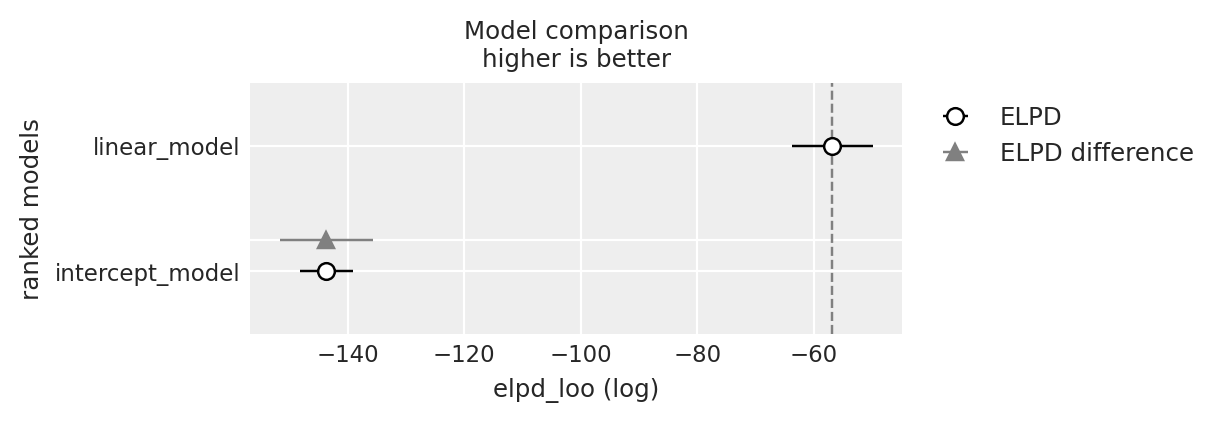

In [23]:
_ = az.plot_compare(df_comp_loo, insample_dev=False)

## Riflessioni Conclusive 

In questo capitolo, abbiamo approfondito il metodo della Validazione Incrociata Leave-One-Out (LOO-CV) come strumento efficace per stimare l'Expected Log Predictive Density (ELPD). Abbiamo illustrato in dettaglio come la LOO-CV possa essere applicata utilizzando il framework cmdstan, evidenziando il suo ruolo cruciale nella pratica della modellazione statistica.

Un aspetto centrale che abbiamo esaminato è l'importanza della LOO-CV nel contesto del confronto tra diversi modelli statistici. Questo metodo non solo aiuta a valutare la capacità predittiva di un singolo modello, ma si rivela anche essenziale quando si tratta di selezionare il modello più adatto tra un insieme di alternative, fornendo una base di confronto oggettiva e affidabile.

Inoltre, abbiamo discusso il ruolo significativo dei valori diagnostici Pareto $k$ nell'interpretazione delle stime ottenute tramite LOO-CV. Abbiamo sottolineato come questi valori siano fondamentali per valutare l'affidabilità delle stime di ELPD derivate dalla LOO-CV, offrendo una misura della precisione e della robustezza di queste stime.

Nel complesso, attraverso questo capitolo, abbiamo mirato a fornire una comprensione completa di come la LOO-CV e i valori diagnostici Pareto $k$ siano impiegati per migliorare la precisione e l'affidabilità delle stime di ELPD, migliorando così la qualità e l'efficacia dei modelli statistici in vari contesti di ricerca e applicazione.

## Informazioni sull'Ambiente di Sviluppo

In [24]:
%load_ext watermark
%watermark -n -u -v -iv -w 

Last updated: Sat Jul 13 2024

Python implementation: CPython
Python version       : 3.12.3
IPython version      : 8.25.0

pingouin  : 0.5.4
logging   : 0.5.1.2
numpy     : 1.26.4
arviz     : 0.18.0
cmdstanpy : 1.2.3
matplotlib: 3.8.4
pandas    : 2.2.2
scipy     : 1.13.1

Watermark: 2.4.3

